<a href="https://colab.research.google.com/github/Dipta04/Ads_Click_Prediction/blob/main/machine_learning_project_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from scipy.stats import randint

### 1. Data Loading

In [2]:
df = pd.read_csv("/content/Social_Network_Ads.csv")

In [3]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [4]:
df.shape

(400, 5)

### Y Data-profiling

In [5]:
!pip install ydata-profiling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.4/400.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.9 MB/s eta 0:00:00


In [6]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Social Network Ads Report")
profile.to_file("report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 5/5 [00:00<00:00, 75.67it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Preprocessing & Pipeline Creation

In [7]:
df.isnull().sum()

,0
User ID,0
Gender,0
Age,0
EstimatedSalary,0
Purchased,0


In [8]:
if 'User ID' in df.columns:
  df.drop(columns = 'User ID', inplace=True)

In [9]:
df.columns.size

4

In [10]:
X = df.drop('Purchased', axis=1)
y = df['Purchased']

In [11]:
numeric_features = X.select_dtypes(include = ['int64', 'float64']).columns
categorical_features = X.select_dtypes(include = ['object']).columns

In [12]:
numeric_features

Index(['Age', 'EstimatedSalary'], dtype='object')

In [13]:
categorical_features

Index(['Gender'], dtype='object')

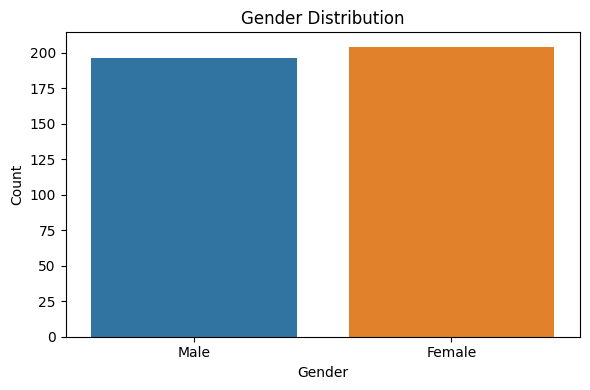

In [14]:
for c in categorical_features:
  plt.figure(figsize=(6,4))
  sns.countplot(data=df, x=c, hue='Gender')
  plt.title("Gender Distribution")
  plt.ylabel("Count")
  plt.tight_layout()
  plt.show()

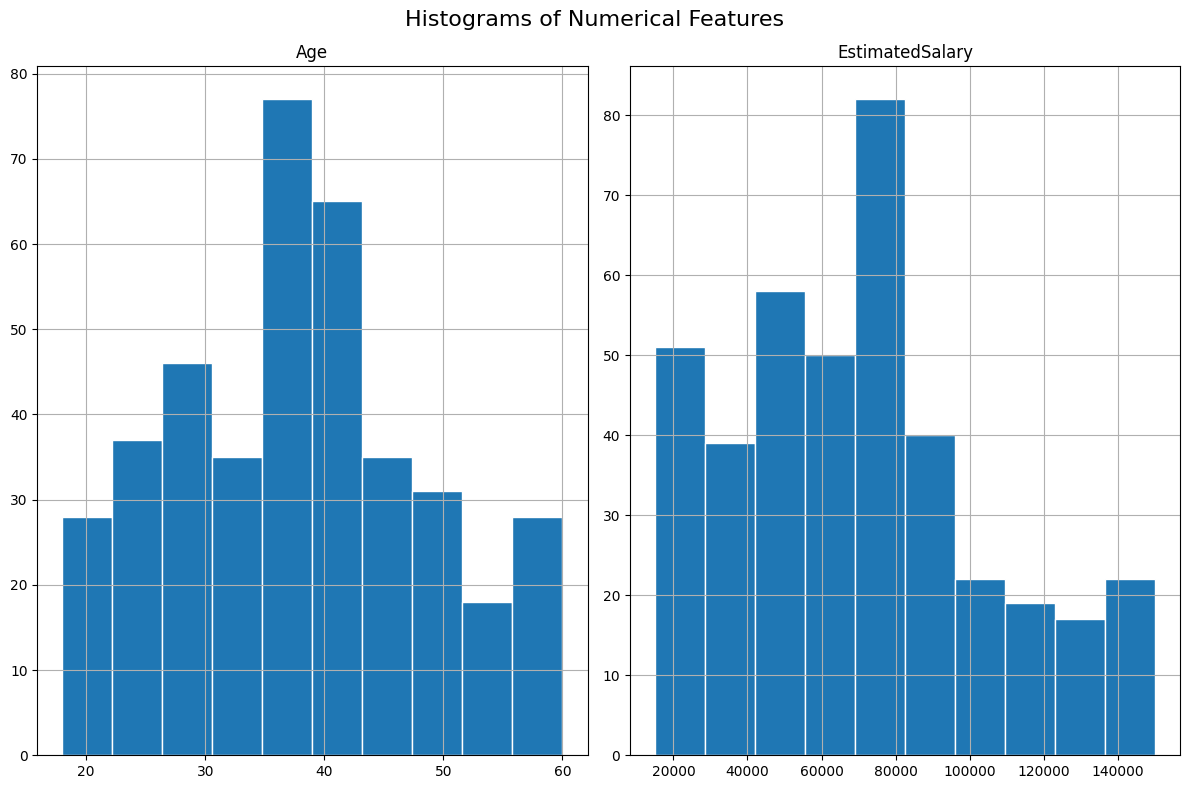

In [15]:
df[numeric_features].hist(bins=10, figsize=(12, 8), edgecolor="white")
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

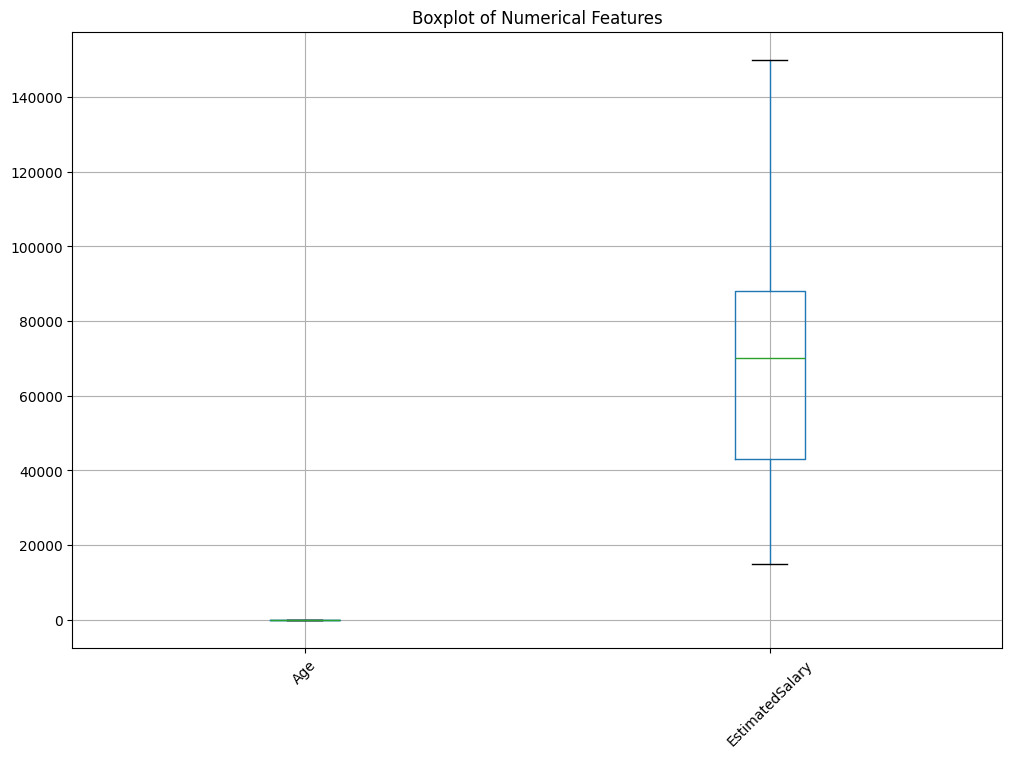

In [16]:
plt.figure(figsize=(12, 8))
df[numeric_features].boxplot()
plt.title("Boxplot of Numerical Features")
plt.xticks(rotation=45)
plt.show()

In [17]:
num_features_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

In [18]:
cat_feature_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('encoder', OrdinalEncoder())
    ]
)

In [19]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_features_transformer, numeric_features),
        ('cat', cat_feature_transformer, categorical_features)
    ]
)

In [20]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Age', 'EstimatedSalary'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder())]),
                                 Index(['Gender'], dtype='object'))])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

### Primary Model Selection

In [22]:
model_lr = LogisticRegression()
model_svm = SVC(gamma='scale', random_state=42)
model_knn = KNeighborsClassifier()
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_xgb = XGBClassifier(n_estimators=100, random_state=42)

In [23]:
voting_model = VotingClassifier(
    estimators = [
        ('lr', model_lr),
        ('svm', model_svm),
        ('knn', model_knn),
        ('rf', model_rf),
        ('xgb', model_xgb)
    ]
)

In [24]:
stacking_model = StackingClassifier(
    estimators = [
        ('lr', model_lr),
        ('svm', model_svm),
        ('knn', model_knn),
        ('rf', model_rf),
        ('xgb', model_xgb)
    ],
    final_estimator=LogisticRegression()
)

### Model Training

In [25]:
model_to_train = {
  'Logistic Regression': model_lr,
  'SVM': model_svm,
  'KNN': model_knn,
  'Random Forest': model_rf,
  'XGBoost': model_xgb,
  'Voting Classifier': voting_model,
  'Stacking Classifier': stacking_model
}

In [26]:
result = []

for name, model in model_to_train.items():
  pipe = Pipeline([
      ('preprocessor', preprocessor),
      ('model', model)
  ])

  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)

  result.append({
      'Model': name,
      'Accuracy': accuracy,
      'F1 Score': f1,
      'Precision': precision,
      'Recall': recall
  })

results_df = pd.DataFrame(result).sort_values('Accuracy', ascending=False)
print(results_df)

                 Model  Accuracy  F1 Score  Precision    Recall
1                  SVM    0.9250  0.896552   0.866667  0.928571
2                  KNN    0.9250  0.896552   0.866667  0.928571
6  Stacking Classifier    0.9250  0.896552   0.866667  0.928571
5    Voting Classifier    0.9125  0.881356   0.838710  0.928571
0  Logistic Regression    0.8875  0.823529   0.913043  0.750000
4              XGBoost    0.8750  0.821429   0.821429  0.821429
3        Random Forest    0.8750  0.821429   0.821429  0.821429


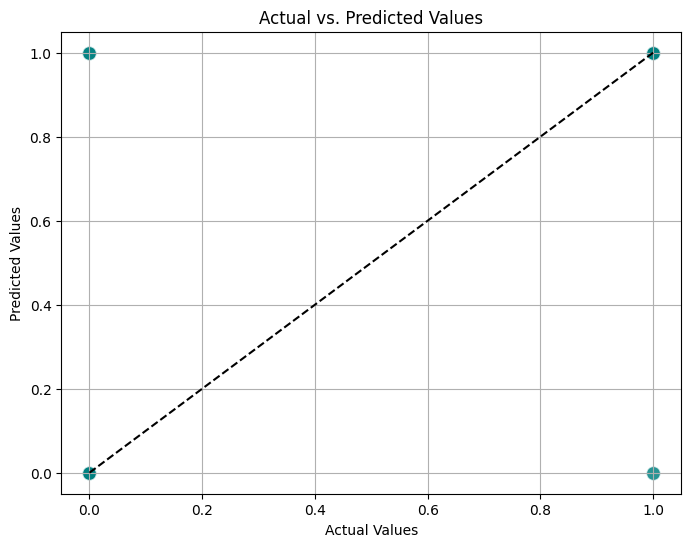

best_model: SVM


In [27]:
best_model = results_df.iloc[0]['Model']
best_model_obj = model_to_train[best_model]

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model_obj)
])

final_pipeline.fit(X_train, y_train)
y_final_pred = final_pipeline.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x = y_test, y = y_final_pred, alpha = 0.6, color = 'teal', s=100)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = "black", linestyle = '--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

print(f'best_model: {best_model}')

### Cross-Validation

In [28]:
#SVM

cv_scores = cross_val_score(final_pipeline, X_train, y_train, cv = 10, scoring="accuracy")

print(cv_scores)

[0.96875 0.875   0.96875 0.96875 0.9375  0.84375 0.875   0.875   0.84375
 0.9375 ]


In [29]:
print(cv_scores.mean())

0.909375


In [30]:
print(cv_scores.std())

0.04931166824393594


In [31]:
#Stacking Model

stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking_model', stacking_model)
])

cv_scores_stacking = cross_val_score(stacking_pipeline, X_train, y_train, cv = 10, scoring="accuracy")

print(cv_scores_stacking)

[0.96875 0.875   0.96875 0.96875 0.9375  0.8125  0.875   0.84375 0.84375
 0.875  ]


In [32]:
print(cv_scores_stacking.mean())

0.896875


In [33]:
print(cv_scores.std())

0.04931166824393594


In [34]:
#KNN

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('KNN', model_knn)
])

cv_scores_knn = cross_val_score(stacking_pipeline, X_train, y_train, cv = 10, scoring="accuracy")

print(cv_scores_knn)

[0.96875 0.875   0.96875 0.96875 0.9375  0.8125  0.875   0.84375 0.84375
 0.875  ]


In [35]:
print(cv_scores_knn.mean())

0.896875


In [36]:
print(cv_scores_knn.std())

0.05598897770990287


### Hyperparameter Tuning

In [37]:
param = {
    'model__C': randint(1,10),
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

In [38]:
random_search = RandomizedSearchCV(
    estimator = final_pipeline,
    param_distributions = param,
    n_iter = 5,
    cv = 10,
    scoring = 'accuracy',
    verbose = 2,
    n_jobs = -1,
    random_state = 42
)

### Best Model Selection

In [39]:
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Age', 'EstimatedSalary'], dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OrdinalEncoder())]),
                                                                               Index(['Gender'], dtype='object'))])),
                                             ('model', SVC(random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e5c88134110>,
                                        'model__gamma': ['scale', 'auto'],
                                        'model__kernel': ['linear', 'rbf',
                                                          'poly', 'sigmoid']},
                   random_state=42, scoring='accuracy', verbose=2)

In [40]:
print(random_search.best_score_)
print("\n")
print(random_search.best_params_)

0.878125


{'model__C': 7, 'model__gamma': 'scale', 'model__kernel': 'poly'}


### Model Perfomance

In [41]:
#Test Data

y_pred_random_search = random_search.predict(X_test)

print(classification_report(y_test, y_pred_random_search))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92        52
           1       0.95      0.71      0.82        28

    accuracy                           0.89        80
   macro avg       0.91      0.85      0.87        80
weighted avg       0.90      0.89      0.88        80



In [42]:
#Train Data

y_train_pred_random_search = random_search.predict(X_train)

print(classification_report(y_train, y_train_pred_random_search))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       205
           1       0.88      0.79      0.83       115

    accuracy                           0.89       320
   macro avg       0.89      0.87      0.87       320
weighted avg       0.89      0.89      0.89       320

